In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
import pandas as pd
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import run_SLAT_multi
from scSLAT.viz import build_3D
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics


In [20]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Stereo_seq\E9.5_E1S1.MOSTA.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

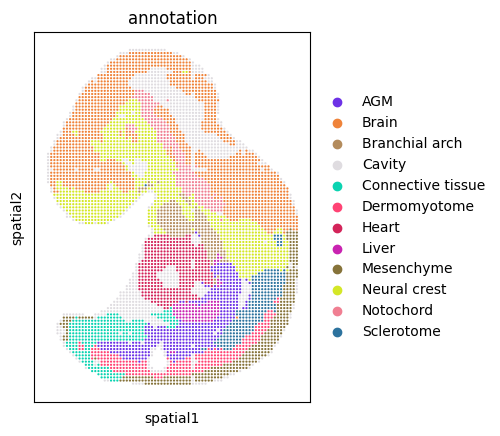

In [21]:
sc.pl.spatial(adata_1, color="annotation", spot_size=0.7)

In [2]:
adata_2=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\Stereo_seq_filter.h5ad")
adata_2

AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [3]:
adata_2.obsm['spatial']

array([[ 108., -147.],
       [ 109., -147.],
       [ 110., -147.],
       ...,
       [ 114., -252.],
       [ 115., -252.],
       [ 116., -252.]])

In [4]:
adata_2.obs_names

Index(['147_108', '147_109', '147_110', '147_111', '147_112', '147_113',
       '147_114', '147_115', '147_116', '147_117',
       ...
       '252_107', '252_108', '252_109', '252_110', '252_111', '252_112',
       '252_113', '252_114', '252_115', '252_116'],
      dtype='object', name='cell_name', length=5031)

In [9]:
spot_size = 2
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

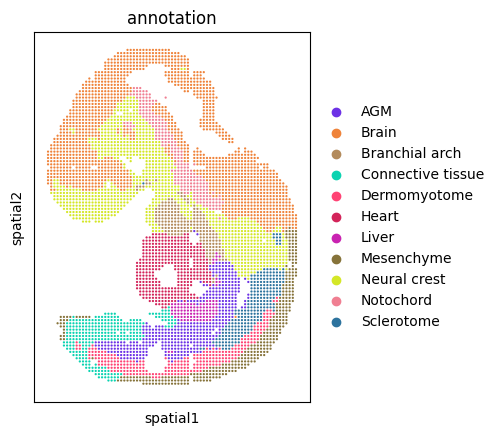

In [15]:
sc.pl.spatial(adata_2, color="annotation", spot_size=0.7)

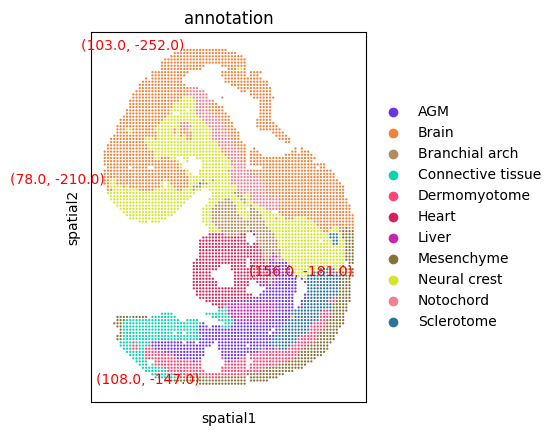

In [17]:
import scanpy as sc
import matplotlib.pyplot as plt

# 生成图像但不立即显示
sc.pl.spatial(adata_2, color="annotation", spot_size=0.7, show=False)

# 获取当前的轴对象
ax = plt.gca()

# 获取坐标
coordinates = adata_2.obsm['spatial']
x_coords = coordinates[:, 0]
y_coords = coordinates[:, 1]

# 找出 x 和 y 的最大值和最小值
x_min_idx = np.argmin(x_coords)
x_max_idx = np.argmax(x_coords)
y_min_idx = np.argmin(y_coords)
y_max_idx = np.argmax(y_coords)

# 标注这些极值点的坐标
for idx in [x_min_idx, x_max_idx, y_min_idx, y_max_idx]:
    x, y = coordinates[idx]
    ax.text(x, y, f"({x:.1f}, {y:.1f})", fontsize=10, ha='right', color='red')

# 显示图像
plt.show()

In [18]:
from anndata import AnnData
import anndata

def display_adata(adata: anndata.AnnData) -> None:
    '''
    Print summary / metadata of annadata object
    '''
    print("Displaying adata Object and their attributes")
    print("Adata attributes and dimensions:")
    display(adata)
    print(f"Matrix sparsity: {adata.X.nnz} filled elements "
      f"({adata.X.nnz/adata.X.shape[0]/adata.X.shape[1]:0.2f}) "
      f"out of {adata.X.shape[0]*adata.X.shape[1]}\n"
      f"max: {np.amax(adata.X.data)}, min: {np.amin(adata.X.data)}")

    # y and x locations / coordinates
    # -------------------------------
    print("\nDisplaying observations (adata.obs)")
    display(adata.obs)

    print("Displaying variables (adata.var)")
    display(adata.var)

In [19]:
display_adata(adata_2)

Displaying adata Object and their attributes
Adata attributes and dimensions:


AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

Matrix sparsity: 19244222 filled elements (0.15) out of 128632608
max: 7.962034225463867, min: 0.46609967947006226

Displaying observations (adata.obs)


,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,annotation,Regulon - 2310011J03Rik,Regulon - 5730507C01Rik,Regulon - Alx1,Regulon - Alx3,Regulon - Alx4,...,Module_25,Module_26,Module_27,Module_28,Module_29,Module_30,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
cell_name,,,,,,,,,,,,,,,,,,,,,
147_108,1627,7.395108,4300,8.366603,Mesenchyme,0.010088,0.134355,0.024699,0.000000,0.047989,...,-0.254721,-0.092710,-0.575457,-0.378378,0.646778,-0.444876,24.674419,34.372093,46.255814,67.302326
147_109,1766,7.477038,4621,8.438583,Mesenchyme,0.000260,0.000000,0.000000,0.000000,0.027797,...,-0.162485,-0.093497,-0.506524,-0.425745,0.679053,-0.435996,22.830556,31.573253,43.259035,64.704609
147_110,1817,7.505492,4695,8.454466,Mesenchyme,0.000000,0.075654,0.039533,0.029540,0.022986,...,-0.331631,-0.060655,-0.494899,-0.467573,0.758527,-0.460582,22.598509,31.863685,43.578275,64.174654
147_111,1797,7.494430,4618,8.437934,Mesenchyme,0.024759,0.088448,0.007836,0.042311,0.032694,...,-0.452190,-0.017362,-0.446368,-0.474456,0.634371,-0.437161,22.932005,31.572109,42.659160,64.161975
147_112,1851,7.524021,5168,8.550435,Mesenchyme,0.013542,0.118989,0.000000,0.049997,0.069963,...,-0.459293,-0.015767,-0.428722,-0.425401,0.663533,-0.499815,22.058824,31.211300,42.976006,63.970588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252_112,3491,8.158230,11298,9.332470,Brain,0.070029,0.050501,0.038851,0.025526,0.124370,...,0.629048,-0.019698,-0.101714,0.090106,0.435168,-0.004698,17.896973,25.323066,34.696406,51.017879
252_113,3230,8.080547,10211,9.231319,Brain,0.009196,0.083042,0.002033,0.000000,0.106416,...,0.355365,0.076965,-0.020394,-0.095547,0.423513,-0.018435,19.057879,26.657526,36.539027,52.982078
252_114,3115,8.044305,9379,9.146335,Brain,0.002224,0.037763,0.012339,0.006520,0.107464,...,0.380168,0.036266,0.009807,-0.102629,0.389888,-0.083199,18.328180,25.802324,35.750080,52.393645


Displaying variables (adata.var)


,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,Regulon - Aco1,Regulon - Adarb1,Regulon - Anxa1,...,Regulon - Zbtb14,Regulon - Zbtb33,Regulon - Zeb1,Regulon - Zfhx2,Regulon - Zfp143,Regulon - Zfp362,Regulon - Zfp740,Regulon - Zfp770,Regulon - Zic2,Regulon - Zmat4
gene_short_name,,,,,,,,,,,,,,,,,,,,,
1700007G11Rik,5779,5779,9.796043,2.379180,2.266193,57924,10.966904,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1700123O20Rik,2349,2349,0.825808,0.602022,60.273973,4883,8.493720,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1810030O07Rik,1450,1450,0.456621,0.376119,75.477761,2700,7.901377,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2010107E04Rik,5764,5764,11.347708,2.513470,2.519871,67099,11.113939,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2210016F16Rik,1271,1271,0.361407,0.308519,78.504989,2137,7.667626,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm32089,1,1,0.000169,0.000169,99.983088,1,0.693147,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Trav13n-1,1,1,0.000338,0.000338,99.983088,2,1.098612,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Gm48436,1,1,0.000169,0.000169,99.983088,1,0.693147,False,False,False,...,False,False,False,False,False,False,False,False,False,False
